In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import keras
from tensorflow.keras.layers import Input, Reshape, Dropout, Dense, Flatten, BatchNormalization, Activation, ZeroPadding2D
from tensorflow.python.keras.layers.advanced_activations import LeakyReLU
from tensorflow.python.keras.layers.convolutional import UpSampling2D, Conv2D
from tensorflow.python.keras.models import Sequential, Model, load_model
from keras.datasets import mnist
from tqdm import tqdm
from tensorflow.python.keras.layers.advanced_activations import LeakyReLU
from tensorflow.python.keras.optimizers import adam

In [19]:
def load_data():
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    x_train = (x_train.astype(np.float32) - 127.5)/127.5
    
    # convert shape of x_train from (60000, 28, 28) to (60000, 784) 
    # 784 columns per row
    x_train = x_train.reshape(60000, 784)
    return (x_train, y_train, x_test, y_test)
(X_train, y_train,X_test, y_test)=load_data()
print(X_train.shape)

(60000, 28, 28)


In [8]:
def adam_optimizer():
    return adam(lr=0.0002, beta_1=0.5)

In [22]:
def create_generator():
    generator=Sequential()
    generator.add(Dense(units=256,input_dim=100))
    generator.add(LeakyReLU(0.2))
    
    generator.add(Dense(units=512))
    generator.add(LeakyReLU(0.2))
    
    generator.add(Dense(units=1024))
    generator.add(LeakyReLU(0.2))
    
    generator.add(Dense(units=784, activation='tanh'))
    
    generator.compile(loss='binary_crossentropy', optimizer=adam_optimizer())
    return generator
g=create_generator()
g.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
dense_24 (Dense)             (None, 1024)              103424    
_________________________________________________________________
reshape_3 (Reshape)          (None, 2, 2, 256)         0         
_________________________________________________________________
up_sampling2d_8 (UpSampling2 (None, 4, 4, 256)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 4, 4, 256)         590080    
_________________________________________________________________
batch_normalization_8 (Batch (None, 4, 4, 256)         1024      
_________________________________________________________________
activation_8 (Activation)    (None, 4, 4, 256)         0   

In [10]:
def create_discriminator():
    discriminator=Sequential()
    discriminator.add(Dense(units=1024,input_dim=784))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
       
    
    discriminator.add(Dense(units=512))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
       
    discriminator.add(Dense(units=256))
    discriminator.add(LeakyReLU(0.2))
    
    discriminator.add(Dense(units=1, activation='sigmoid'))
    
    discriminator.compile(loss='binary_crossentropy', optimizer=adam_optimizer())
    return discriminator
d =create_discriminator()
d.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 1024)              803840    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 1024)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 512)               524800    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 256)              

In [11]:
def create_gan(discriminator, generator):
    discriminator.trainable=False
    gan_input = Input(shape=(100,))
    x = generator(gan_input)
    gan_output= discriminator(x)
    gan= Model(inputs=gan_input, outputs=gan_output)
    gan.compile(loss='binary_crossentropy', optimizer='adam')
    return gan
gan = create_gan(d,g)
gan.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 784)               1486352   
_________________________________________________________________
sequential_2 (Sequential)    (None, 1)                 1460225   
Total params: 2,946,577
Trainable params: 1,486,352
Non-trainable params: 1,460,225
_________________________________________________________________


In [12]:
def plot_generated_images(epoch, generator, examples=100, dim=(10,10), figsize=(10,10)):
    noise= np.random.normal(loc=0, scale=1, size=[examples, 100])
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(100,28,28)
    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], interpolation='nearest')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('gan_generated_image %d.png' %epoch)

In [16]:
np.random.normal(0,1, [32, 100]).shape

(32, 100)

  0%|          | 0/128 [00:00<?, ?it/s]WARNING: Logging before flag parsing goes to stderr.
W0821 20:32:38.829216 4423665088 deprecation.py:323] From /Users/sizhenhan/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1


  2%|▏         | 2/128 [00:00<00:06, 19.59it/s]

Epoch 2


  2%|▏         | 3/128 [00:00<00:05, 21.20it/s]

Epoch 3


  2%|▏         | 3/128 [00:00<00:05, 22.48it/s]

Epoch 4


  2%|▏         | 3/128 [00:00<00:05, 20.98it/s]

Epoch 5


  2%|▏         | 3/128 [00:00<00:05, 23.81it/s]

Epoch 6


  2%|▏         | 3/128 [00:00<00:05, 22.00it/s]

Epoch 7


  2%|▏         | 3/128 [00:00<00:05, 21.72it/s]

Epoch 8


  2%|▏         | 3/128 [00:00<00:05, 21.01it/s]

Epoch 9


  2%|▏         | 3/128 [00:00<00:05, 21.76it/s]

Epoch 10


  2%|▏         | 3/128 [00:00<00:05, 22.00it/s]

Epoch 11


  2%|▏         | 3/128 [00:00<00:05, 22.03it/s]

Epoch 12


  2%|▏         | 3/128 [00:00<00:05, 22.54it/s]

Epoch 13


  2%|▏         | 3/128 [00:00<00:05, 21.59it/s]

Epoch 14


  2%|▏         | 3/128 [00:00<00:05, 21.46it/s]

Epoch 15


  2%|▏         | 3/128 [00:00<00:05, 22.35it/s]

Epoch 16


  2%|▏         | 3/128 [00:00<00:06, 19.95it/s]

Epoch 17


  2%|▏         | 2/128 [00:00<00:07, 16.91it/s]

Epoch 18


  2%|▏         | 3/128 [00:00<00:06, 20.62it/s]

Epoch 19


  2%|▏         | 3/128 [00:00<00:05, 21.89it/s]

Epoch 20


  2%|▏         | 2/128 [00:00<00:06, 18.07it/s]

Epoch 21


  2%|▏         | 3/128 [00:00<00:05, 20.85it/s]

Epoch 22


  2%|▏         | 3/128 [00:00<00:05, 21.04it/s]

Epoch 23


  2%|▏         | 3/128 [00:00<00:05, 23.02it/s]

Epoch 24


  2%|▏         | 3/128 [00:00<00:05, 24.41it/s]

Epoch 25


  2%|▏         | 3/128 [00:00<00:05, 21.75it/s]

Epoch 26


  2%|▏         | 3/128 [00:00<00:05, 22.97it/s]

Epoch 27


  2%|▏         | 3/128 [00:00<00:05, 22.96it/s]

Epoch 28


  2%|▏         | 3/128 [00:00<00:05, 23.42it/s]

Epoch 29


  2%|▏         | 3/128 [00:00<00:05, 23.08it/s]

Epoch 30


  2%|▏         | 3/128 [00:00<00:05, 22.95it/s]

Epoch 31


  2%|▏         | 3/128 [00:00<00:05, 22.80it/s]

Epoch 32


  2%|▏         | 3/128 [00:00<00:05, 23.76it/s]

Epoch 33


  2%|▏         | 3/128 [00:00<00:05, 23.86it/s]

Epoch 34


  2%|▏         | 3/128 [00:00<00:05, 23.42it/s]

Epoch 35


  2%|▏         | 3/128 [00:00<00:05, 22.59it/s]

Epoch 36


  2%|▏         | 3/128 [00:00<00:05, 21.86it/s]

Epoch 37


  2%|▏         | 3/128 [00:00<00:05, 23.58it/s]

Epoch 38


  2%|▏         | 3/128 [00:00<00:05, 22.43it/s]

Epoch 39


  2%|▏         | 3/128 [00:00<00:05, 22.59it/s]

Epoch 40


  2%|▏         | 3/128 [00:00<00:05, 22.76it/s]

Epoch 41


  2%|▏         | 3/128 [00:00<00:05, 23.72it/s]

Epoch 42


  2%|▏         | 3/128 [00:00<00:05, 22.19it/s]

Epoch 43


 59%|█████▉    | 76/128 [00:03<00:02, 20.87it/s]


KeyboardInterrupt: 

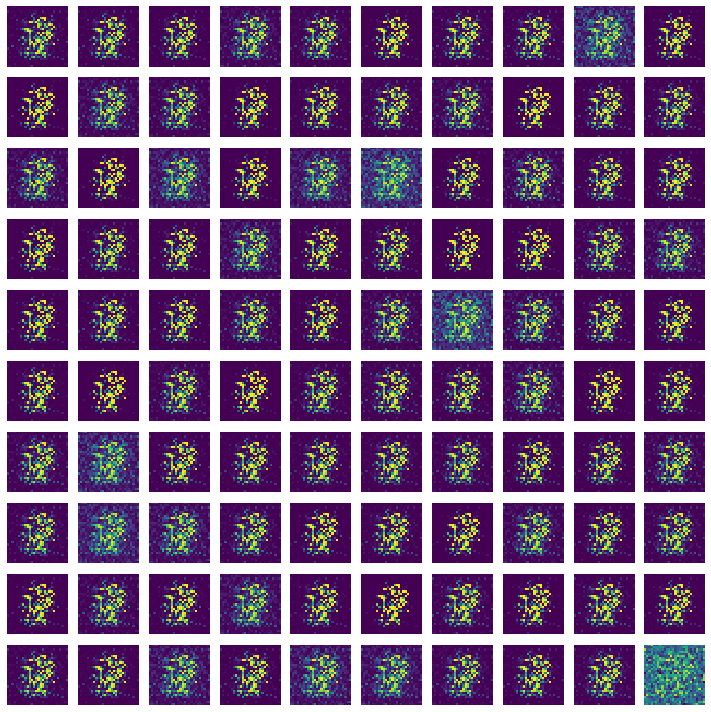

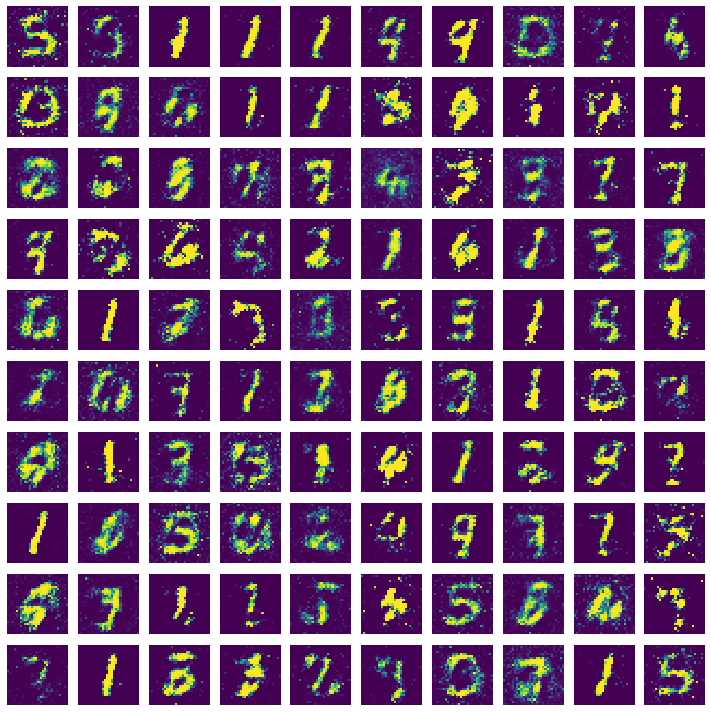

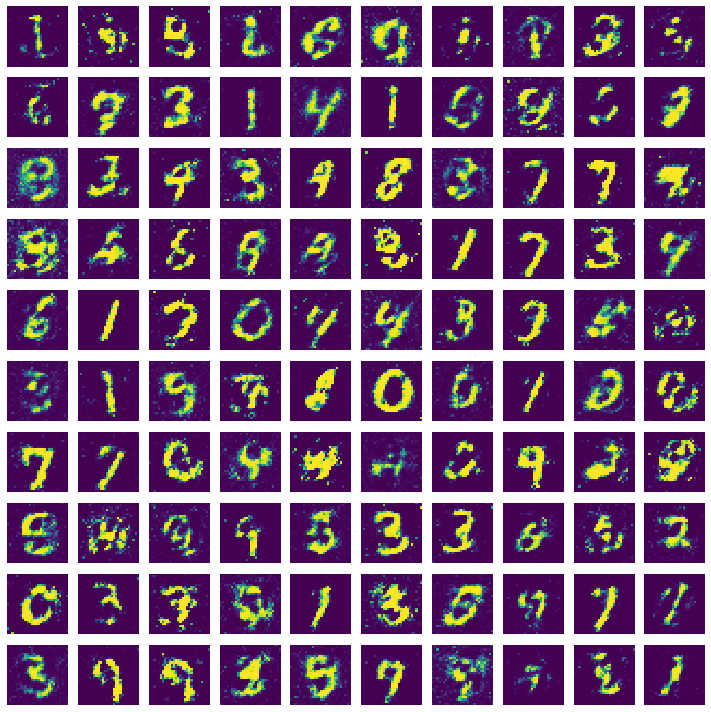

In [13]:
def training(epochs=1, batch_size=128):
    
    #Loading the data
    (X_train, y_train, X_test, y_test) = load_data()
    batch_count = X_train.shape[0] / batch_size
    
    # Creating GAN
    generator= create_generator()
    discriminator= create_discriminator()
    gan = create_gan(discriminator, generator)
    
    for e in range(1,epochs+1 ):
        print("Epoch %d" %e)
        for _ in tqdm(range(batch_size)):
        #generate  random noise as an input  to  initialize the  generator
            noise= np.random.normal(0,1, [batch_size, 100])
            
            # Generate fake MNIST images from noised input
            generated_images = generator.predict(noise)
            
            # Get a random set of  real images
            image_batch =X_train[np.random.randint(low=0,high=X_train.shape[0],size=batch_size)]
            
            #Construct different batches of  real and fake data 
            X= np.concatenate([image_batch, generated_images])
            
            # Labels for generated and real data
            y_dis=np.zeros(2*batch_size)
            y_dis[:batch_size]=0.9
            
            #Pre train discriminator on  fake and real data  before starting the gan. 
            discriminator.trainable=True
            discriminator.train_on_batch(X, y_dis)
            
            #Tricking the noised input of the Generator as real data
            noise= np.random.normal(0,1, [batch_size, 100])
            y_gen = np.ones(batch_size)
            
            # During the training of gan, 
            # the weights of discriminator should be fixed. 
            #We can enforce that by setting the trainable flag
            discriminator.trainable=False
            
            #training  the GAN by alternating the training of the Discriminator 
            #and training the chained GAN model with Discriminator’s weights freezed.
            gan.train_on_batch(noise, y_gen)
            
        if e == 1 or e % 20 == 0:
           
            plot_generated_images(e, generator)
training(400,128)